____
__Universidad de San Andrés__<br/>
__Visión Artificial__<br/>
__Trabajo Práctico 1: Panorámica__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Visualizamos las imágenes

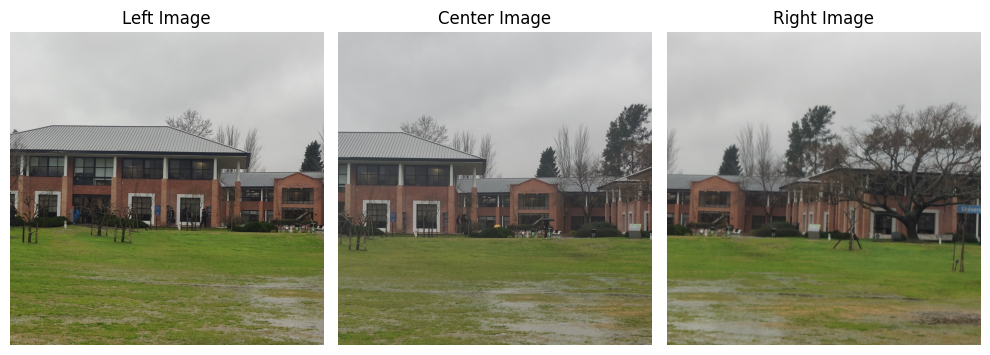

In [26]:
# cargo las imágenes (open cv las carga en bgr)
udesa_left = cv2.imread("img/udesa_0.jpg", flags=cv2.IMREAD_COLOR)
udesa_center = cv2.imread("img/udesa_1.jpg", flags=cv2.IMREAD_COLOR)
udesa_right = cv2.imread("img/udesa_2.jpg", flags=cv2.IMREAD_COLOR)

# convierto a rgb
udesa_left = cv2.cvtColor(udesa_left, cv2.COLOR_BGR2RGB)
udesa_center = cv2.cvtColor(udesa_center, cv2.COLOR_BGR2RGB)
udesa_right = cv2.cvtColor(udesa_right, cv2.COLOR_BGR2RGB)

# muestro las imágenes
fig, ax = plt.subplots(1, 3, figsize=(10, 15))
ax[0].imshow(udesa_left)
ax[0].set_title("Left Image")
ax[0].axis('off')

ax[1].imshow(udesa_center)
ax[1].set_title("Center Image")
ax[1].axis('off')

ax[2].imshow(udesa_right)
ax[2].set_title("Right Image")
ax[2].axis('off')
plt.tight_layout()
plt.show()

### Seguimos el pipeline propuesto

#### Paso 1: Detección de características visuales

Cantidad de keypoints en la imagen izquierda: 22107
Cantidad de keypoints en la imagen central: 14852
Cantidad de keypoints en la imagen derecha: 5363


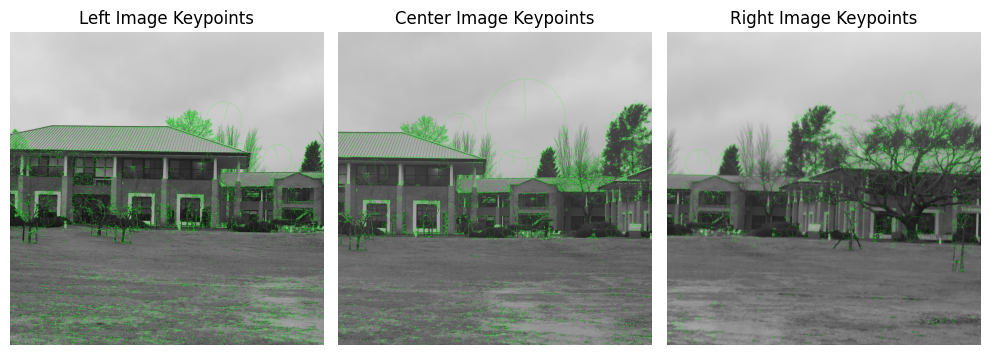

In [27]:
# se pueden usar: sift, surf, akaze, orb
# pruebo primero con sift

# primero convierto las imágenes a escala de grises
udesa_left = cv2.cvtColor(udesa_left, cv2.COLOR_RGB2GRAY)
udesa_center = cv2.cvtColor(udesa_center, cv2.COLOR_RGB2GRAY)
udesa_right = cv2.cvtColor(udesa_right, cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()

# detecto keypoints y computo descriptores
keypoints_left, descriptors_left = sift.detectAndCompute(udesa_left, None)
keypoints_center, descriptors_center = sift.detectAndCompute(udesa_center, None)
keypoints_right, descriptors_right = sift.detectAndCompute(udesa_right, None)

print(f'Cantidad de keypoints en la imagen izquierda: {len(keypoints_left)}')
print(f'Cantidad de keypoints en la imagen central: {len(keypoints_center)}')
print(f'Cantidad de keypoints en la imagen derecha: {len(keypoints_right)}')

# dibujo keypoints
img_keypoints_left = cv2.drawKeypoints(udesa_left, keypoints_left, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_keypoints_center = cv2.drawKeypoints(udesa_center, keypoints_center, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_keypoints_right = cv2.drawKeypoints(udesa_right, keypoints_right, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)   

# muestro las imágenes con keypoints
fig, ax = plt.subplots(1, 3, figsize=(10, 15))
ax[0].imshow(img_keypoints_left)
ax[0].set_title('Left Image Keypoints')
ax[0].axis('off')

ax[1].imshow(img_keypoints_center)
ax[1].set_title('Center Image Keypoints')
ax[1].axis('off')

ax[2].imshow(img_keypoints_right)
ax[2].set_title('Right Image Keypoints')
ax[2].axis('off')
plt.tight_layout()
plt.show()


#### Paso 2: Supresión de No Máxima Adaptativa

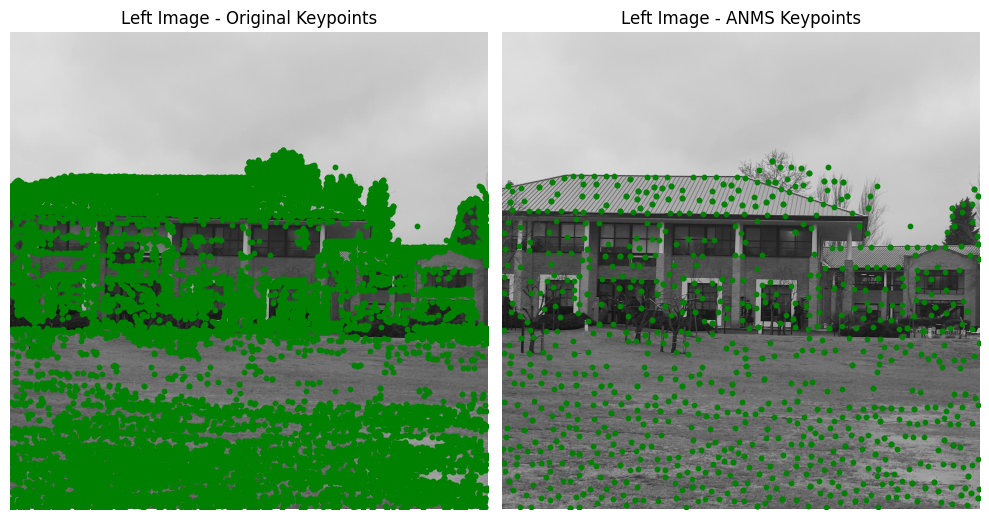

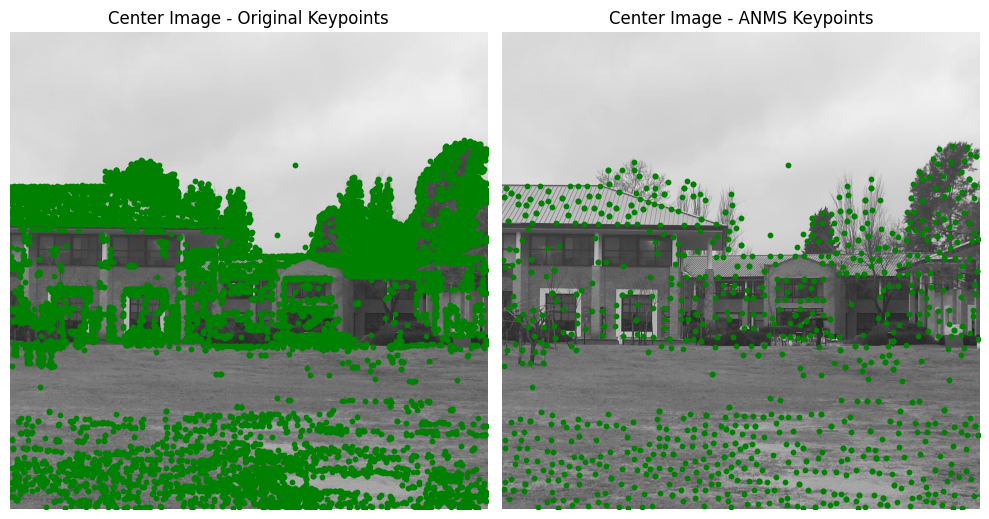

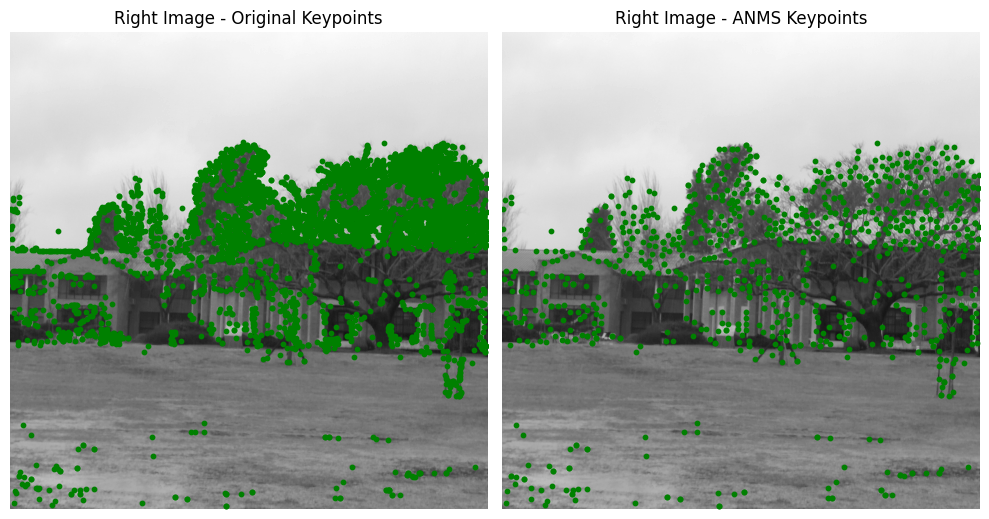

In [31]:
def anms(keypoints, descriptors, num_points):

    if len(keypoints) <= num_points:
        return keypoints, descriptors
    
    # inicializo los radios de supresión
    radii = [float('inf')] * len(keypoints)

    # calculo los radios de supresión
    for i in range(len(keypoints)):
        for j in range(len(keypoints)):
            if keypoints[j].response > keypoints[i].response:
                dx = keypoints[i].pt[0] - keypoints[j].pt[0]
                dy = keypoints[i].pt[1] - keypoints[j].pt[1]
                dist = dx*dx + dy*dy
                if dist < radii[i]:
                    radii[i] = dist

    # asocio cada radio con su keypoint y ordeno por radio
    keypoints_radii = list(zip(keypoints, radii))
    keypoints_radii.sort(key=lambda x: x[1], reverse=True)

    # selecciono los primeros num_points keypoints y sus descriptores
    selected_keypoints = [kp for kp, r in keypoints_radii[:num_points]]

    selected_indices = [keypoints.index(kp) for kp in selected_keypoints]
    selected_descriptors = descriptors[selected_indices]

    selected_radii = [r for kp, r in keypoints_radii[:num_points]]

    return selected_keypoints, selected_descriptors, selected_radii

# aplico anms para quedarme con 1000 keypoints por imagen
num_keypoints = 1000
keypoints_left_anms, descriptors_left_anms, radii_left = anms(keypoints_left, descriptors_left, num_keypoints)
keypoints_center_anms, descriptors_center_anms, radii_center = anms(keypoints_center, descriptors_center, num_keypoints)
keypoints_right_anms, descriptors_right_anms, radii_right = anms(keypoints_right, descriptors_right, num_keypoints)

def plot_new_keypoints(image, old_keypoints, new_keypoints, image_name):
    fig, ax = plt.subplots(1, 2, figsize=(10, 15))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title(f'{image_name} - Original Keypoints')
    ax[0].axis('off')
    ax[0].scatter([kp.pt[0] for kp in old_keypoints], [kp.pt[1] for kp in old_keypoints], s=10, c='g', marker='o')

    ax[1].imshow(image, cmap='gray')
    ax[1].set_title(f'{image_name} - ANMS Keypoints')
    ax[1].axis('off')
    ax[1].scatter([kp.pt[0] for kp in new_keypoints], [kp.pt[1] for kp in new_keypoints], s=10, c='g', marker='o')
    plt.tight_layout()
    plt.show()

# muestro las imágenes con los nuevos keypoints
plot_new_keypoints(udesa_left, keypoints_left, keypoints_left_anms, 'Left Image')
plot_new_keypoints(udesa_center, keypoints_center, keypoints_center_anms, 'Center Image')
plot_new_keypoints(udesa_right, keypoints_right, keypoints_right_anms, 'Right Image')

#### Paso 3: Descripción de las características

Left–Center -> Lowe+Cross: 102 matches
Right–Center -> Lowe+Cross: 30 matches


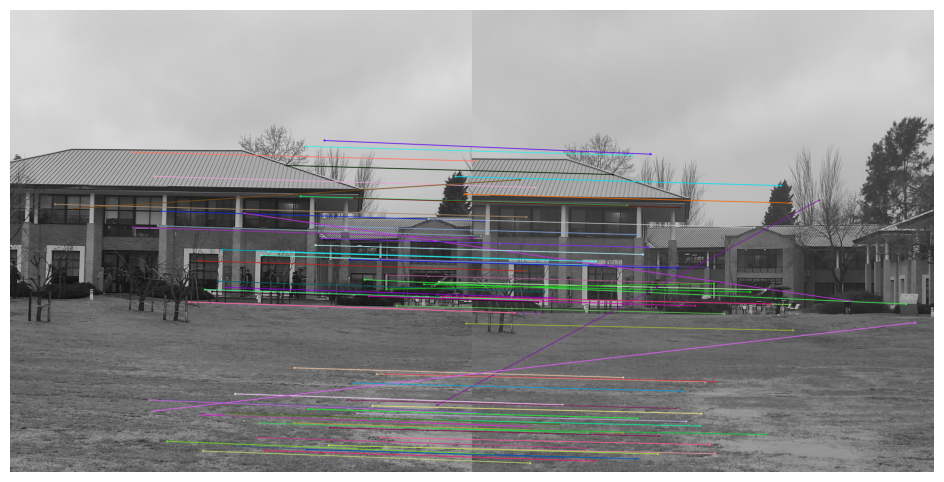

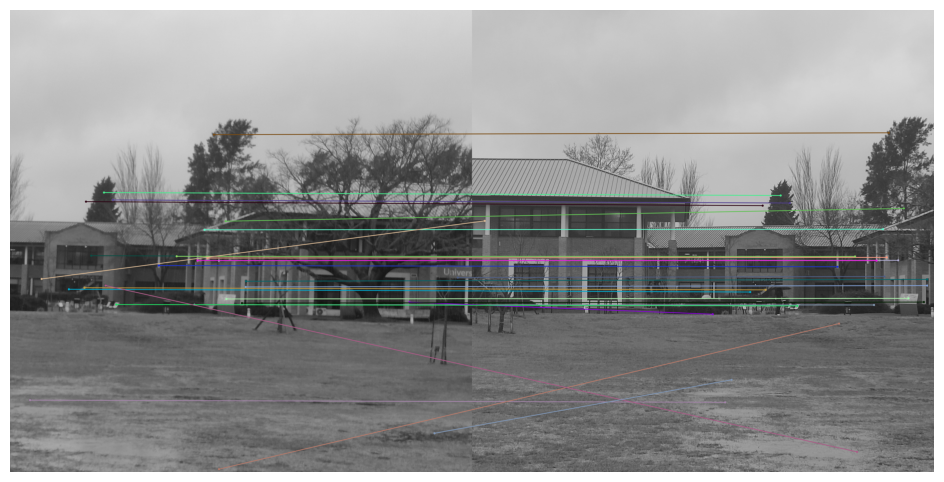

In [32]:
# --- util mínimo para mostrar matches cuando las imágenes están en RGB (plt/PIL) ---
def _u8(img):
    return (img*255).astype(np.uint8) if img.dtype!=np.uint8 else img

def show_matches_rgb(img1_rgb, kps1, img2_rgb, kps2, matches, max_show=60, title=""):
    img1_u8 = _u8(img1_rgb); img2_u8 = _u8(img2_rgb)
    draw = cv2.drawMatches(cv2.cvtColor(img1_u8, cv2.COLOR_RGB2BGR), kps1,
                           cv2.cvtColor(img2_u8, cv2.COLOR_RGB2BGR), kps2,
                           matches[:max_show], None,
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off'); plt.show()

# --- elegir norma según descriptor (SIFT -> L2, ORB/BRIEF -> Hamming) ---
def _norm_for(desc):
    return cv2.NORM_L2 if desc.dtype==np.float32 else cv2.NORM_HAMMING

# 1) Lowe ratio
def match_lowe(kps1, desc1, kps2, desc2, ratio=0.75):
    """
    Matchea con kNN(k=2) + filtro de Lowe.
    Devuelve (matches_ordenados, pts1, pts2).
    """
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return [], np.empty((0,2), np.float32), np.empty((0,2), np.float32)

    matcher = cv2.BFMatcher(_norm_for(desc1), crossCheck=False)
    knn = matcher.knnMatch(desc1, desc2, k=2)

    good = []
    for pair in knn:
        if len(pair)<2: continue
        m, n = pair
        if m.distance < ratio * n.distance:
            good.append(m)

    good.sort(key=lambda x: x.distance)
    pts1 = np.array([kps1[m.queryIdx].pt for m in good], np.float32)
    pts2 = np.array([kps2[m.trainIdx].pt for m in good], np.float32)
    return good, pts1, pts2

# 2) Cross-check (mejor vecino recíproco)
def match_crosscheck(kps1, desc1, kps2, desc2):
    """
    Matchea con mejor vecino y verificación cruzada (mutua).
    Devuelve (matches_ordenados, pts1, pts2).
    """
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return [], np.empty((0,2), np.float32), np.empty((0,2), np.float32)

    # BF con crossCheck=True ya hace verificación recíproca
    matcher = cv2.BFMatcher(_norm_for(desc1), crossCheck=True)
    matches = matcher.match(desc1, desc2)
    matches.sort(key=lambda x: x.distance)

    pts1 = np.array([kps1[m.queryIdx].pt for m in matches], np.float32)
    pts2 = np.array([kps2[m.trainIdx].pt for m in matches], np.float32)
    return matches, pts1, pts2

# 3) Combinado: Lowe primero y después verificación cruzada manual sobre los mejores vecinos
def match_lowe_cross(kps1, desc1, kps2, desc2, ratio=0.75):
    """
    Combina Lowe + verificación cruzada (mutua).
    Devuelve (matches_ordenados, pts1, pts2).
    """
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return [], np.empty((0,2), np.float32), np.empty((0,2), np.float32)

    norm = _norm_for(desc1)
    # Lowe
    bf12 = cv2.BFMatcher(norm, crossCheck=False)
    knn12 = bf12.knnMatch(desc1, desc2, k=2)
    cand = []
    for pair in knn12:
        if len(pair)<2: continue
        m, n = pair
        if m.distance < ratio * n.distance:
            cand.append(m)

    # mapa mejor vecino 2->1
    bf21 = cv2.BFMatcher(norm, crossCheck=False)
    knn21 = bf21.knnMatch(desc2, desc1, k=1)
    best21 = {m.queryIdx: m.trainIdx for [m] in knn21}

    # verificación recíproca sobre los candidatos de Lowe
    good = [m for m in cand if best21.get(m.trainIdx, -1) == m.queryIdx]
    good.sort(key=lambda x: x.distance)

    pts1 = np.array([kps1[m.queryIdx].pt for m in good], np.float32)
    pts2 = np.array([kps2[m.trainIdx].pt for m in good], np.float32)
    return good, pts1, pts2

import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_matches_thick_rgb(img1_rgb, kps1, img2_rgb, kps2, matches,
                           max_show=60, thickness=3, radius=6):
    """
    Dibuja matches con control de grosor de líneas y tamaño de puntos.
    - img*_rgb: imágenes en RGB (plt/PIL)
    - kps*: listas de cv2.KeyPoint
    - matches: lista de cv2.DMatch
    """
    # asegurar uint8
    img1 = (img1_rgb*255).astype(np.uint8) if img1_rgb.dtype!=np.uint8 else img1_rgb
    img2 = (img2_rgb*255).astype(np.uint8) if img2_rgb.dtype!=np.uint8 else img2_rgb

    # convertir a BGR para dibujar con OpenCV
    im1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    im2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

    # crear lienzo lado a lado
    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]
    H = max(h1, h2)
    canvas = np.zeros((H, w1 + w2, 3), dtype=np.uint8)
    canvas[:h1, :w1] = im1
    canvas[:h2, w1:w1+w2] = im2

    # dibujar
    rng = np.random.default_rng(0)  # colores reproducibles
    for m in matches[:max_show]:
        p1 = tuple(int(v) for v in kps1[m.queryIdx].pt)
        p2 = tuple(int(v) for v in kps2[m.trainIdx].pt)
        p2_off = (p2[0] + w1, p2[1])  # offset a la derecha

        color = tuple(int(c) for c in rng.integers(0, 255, size=3))  # BGR aleatorio

        # puntos gordos
        cv2.circle(canvas, p1, radius, color, -1)
        cv2.circle(canvas, p2_off, radius, color, -1)
        # línea gruesa
        cv2.line(canvas, p1, p2_off, color, thickness, lineType=cv2.LINE_AA)

    # mostrar en RGB
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,6))
    plt.imshow(canvas_rgb)
    plt.axis('off')
    plt.show()


# ===== Ejecutá con tu imagen ancla (center) =====
# Con SIFT, desc son float32 -> norma L2
ratio = 0.75

# Left ↔ Center (combinado recomendado)
m_LC, ptsL, ptsC_L = match_lowe_cross(keypoints_left_anms, descriptors_left_anms, keypoints_center_anms, descriptors_center_anms, ratio=ratio)
print(f"Left–Center -> Lowe+Cross: {len(m_LC)} matches")

# Right ↔ Center (combinado recomendado)
m_RC, ptsR, ptsC_R = match_lowe_cross(keypoints_right_anms, descriptors_right_anms, keypoints_center_anms, descriptors_center_anms, ratio=ratio)
print(f"Right–Center -> Lowe+Cross: {len(m_RC)} matches")

draw_matches_thick_rgb(udesa_left,  keypoints_left_anms, udesa_center, keypoints_center_anms, m_LC,
                       max_show=80, thickness=4, radius=7)

draw_matches_thick_rgb(udesa_right, keypoints_right_anms, udesa_center, keypoints_center_anms, m_RC,
                       max_show=80, thickness=4, radius=7)
# ...existing code...


# (si querés comparar políticas, probá:)
# mL_only, _, _  = match_lowe(kpsL_anms, descL_anms, kpsC_anms, descC_anms, ratio=0.75)
# mCC_only, _, _ = match_crosscheck(kpsL_anms, descL_anms, kpsC_anms, descC_anms)
# print(len(mL_only), len(mCC_only))


#### Paso 4: Estimación de la homografía

Homografía H (center -> left):
 [[ 9.75743024e-01  1.76890031e-02  8.92219598e+02]
 [-1.47204017e-02  1.04686515e+00 -1.07406894e+02]
 [-1.80522129e-05  1.75302461e-05  1.00000000e+00]]


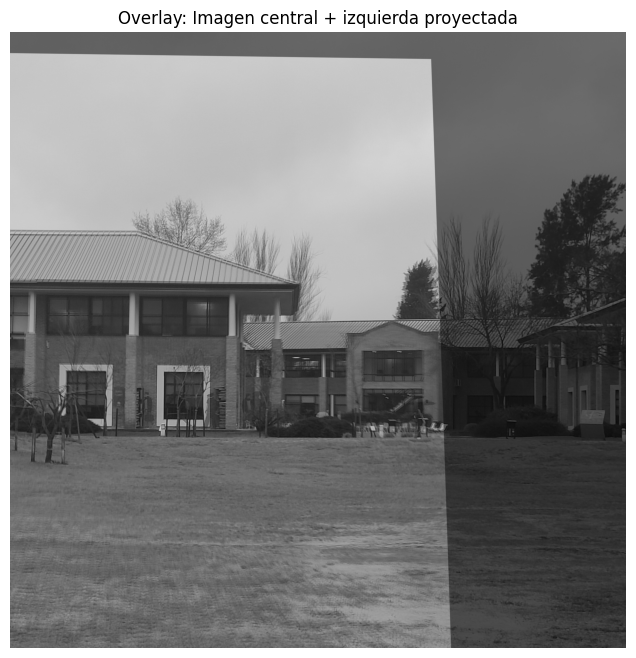

In [39]:
# elegi los puntos usando script.py

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Puntos en la imagen central
pts_center = np.array([
    [264.66, 2121.49],
    [609.03, 1490.15],
    [1058.07, 1956.06],
    [1412.56, 1240.31]
])

# Puntos correspondientes en la imagen izquierda
pts_left = np.array([
    [1150.69, 2043.38],
    [1490.29, 1422.10],
    [1929.91, 1895.95],
    [2301.10, 1174.65]
])

# Función para calcular homografía por DLT
def compute_homography(src_pts, dst_pts):
    A = []
    for (x, y), (xp, yp) in zip(src_pts, dst_pts):
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
    A = np.array(A)
    
    # SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape(3,3)
    H = H / H[2,2]  # normalizar
    return H

# Calcular homografía
H_left_to_center = compute_homography(pts_center, pts_left)
print("Homografía H (center -> left):\n", H_left_to_center)

# Aplicar homografía a la imagen izquierda
h, w = udesa_center.shape[:2]
img_left_warped = cv2.warpPerspective(udesa_left, np.linalg.inv(H_left_to_center), (w, h))

alpha = 0.5  # transparencia de la imagen izquierda
overlay = cv2.addWeighted(cv2.cvtColor(udesa_center, cv2.COLOR_BGR2RGB), 1-alpha,
                          cv2.cvtColor(img_left_warped, cv2.COLOR_BGR2RGB), alpha, 0)

plt.figure(figsize=(12,8))
plt.imshow(overlay)
plt.title("Overlay: Imagen central + izquierda proyectada")
plt.axis("off")
plt.show()

#### Paso 5: Estimación de la homografía pero usando RANSAC

Homografía con RANSAC H (center -> left):
 [[ 9.44452084e-01 -9.54759276e-03  9.16531742e+02]
 [-1.73437153e-02  9.82897382e-01 -4.04202012e+01]
 [-1.61217766e-05  2.90800864e-08  1.00000000e+00]]


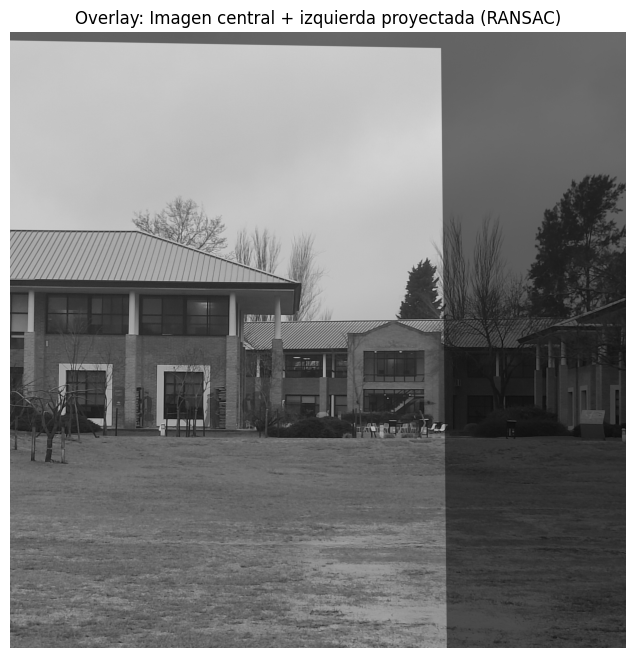

In [40]:
# implemento ransac

def ransac_homography(pts1, pts2, thresh=5.0, max_iters=1000, confidence=0.99):
    best_H = None
    best_inliers = []
    n_points = pts1.shape[0]
    best_inlier_count = 0
    for _ in range(max_iters):
        # seleccionar 4 puntos aleatorios
        indices = np.random.choice(n_points, 4, replace=False)
        src_sample = pts1[indices]
        dst_sample = pts2[indices]
        
        # calcular homografía
        H = compute_homography(src_sample, dst_sample)
        
        # proyectar todos los puntos
        pts1_homog = np.hstack([pts1, np.ones((n_points, 1))])
        projected_pts2_homog = (H @ pts1_homog.T).T
        projected_pts2 = projected_pts2_homog[:, :2] / projected_pts2_homog[:, 2:3]
        
        # calcular errores
        errors = np.linalg.norm(projected_pts2 - pts2, axis=1)
        
        # determinar inliers
        inliers = np.where(errors < thresh)[0]
        inlier_count = len(inliers)
        
        # actualizar mejor modelo si es necesario
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_inliers = inliers
            best_H = H
            
            # calcular probabilidad de éxito y ajustar iteraciones si es necesario
            inlier_ratio = inlier_count / n_points
            p_no_outliers = 1 - inlier_ratio**4
            p_no_outliers = max(p_no_outliers, 1e-8)  # evitar log(0)
            max_iters = min(max_iters, int(np.log(1 - confidence) / np.log(p_no_outliers)))
    
    # recalcular homografía con todos los inliers encontrados
    if len(best_inliers) >= 4:
        best_H = compute_homography(pts1[best_inliers], pts2[best_inliers])
    
    return best_H, best_inliers

# aplicar RANSAC
H_ransac, inliers = ransac_homography(ptsC_L,
                                        ptsL,
                                        thresh=5.0,
                                        max_iters=1000,
                                        confidence=0.99)

print("Homografía con RANSAC H (center -> left):\n", H_ransac)
# aplicar homografía a la imagen izquierda
h, w = udesa_center.shape[:2]
img_left_warped_ransac = cv2.warpPerspective(udesa_left,
                                                np.linalg.inv(H_ransac),
                                                (w, h))
overlay_ransac = cv2.addWeighted(cv2.cvtColor(udesa_center, cv2.COLOR_BGR2RGB), 1-alpha,
                                    cv2.cvtColor(img_left_warped_ransac, cv2.COLOR_BGR2RGB), alpha, 0)
plt.figure(figsize=(12,8))
plt.imshow(overlay_ransac)
plt.title("Overlay: Imagen central + izquierda proyectada (RANSAC)")
plt.axis("off") 
plt.show()

#### Paso 6: Cálculo de tamaño óptimo para imagen final